In [329]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import joblib

In [330]:
def add(low, high, reverse=False):
    if reverse:
        return [random.randint(low, high) if i <= 0.5 else low for i in resigned]
    else:
        return [low if i <= 0.5 else random.randint(low, high) for i in resigned]

In [331]:
# Установка начальных параметров
random.seed(42)  # Зафиксируем seed для воспроизводимости результатов
np.random.seed(42)
num_samples = 3000  # Количество записей
start_date = datetime(2023, 1, 1)  # Начальная дата
work_hours_start = 9  # Начало рабочего дня
work_hours_end = 17  # Конец рабочего дня
time_to_read = 4  # Часы до прочтения
stress_keywords = ['stress', 'deadline', 'overwork']  # Ключевые слова для стресса
salary_change_keywords = ['salary', 'pay raise', 'compensation']  # Ключевые слова про изменение зарплаты
vacation_keywords = ['vacation', 'leave', 'time off']  # Ключевые слова про отпуск

# Генерация последовательных ID
starting_id = 1000  # Начальное значение ID
num_users = num_samples  # Количество пользователей

user_ids = [starting_id + i for i in range(num_users)]

def rand_group(x):
    return random.randint(1, 5)
rand_groups = [rand_group(1) for _ in range(num_samples)]

In [365]:
for i in range(1, 4):
    # Генерация чисел в пропорциях 80% и 20%
    percent_greater_than_05 = 0.3  # Процент чисел больше 0.5

    # Создание массива чисел от 0 до 1
    numbers = np.random.rand(num_samples)

    # Определение количества чисел больше и меньше 0.5
    num_greater_than_05 = int(num_samples * percent_greater_than_05)
    num_less_than_05 = num_samples - num_greater_than_05

    # Установка значений
    numbers[num_greater_than_05:] *= 0.5  # Уменьшение чисел, начиная с определенного индекса

    # Пример значений
    print(numbers)

    # Целевая переменная
    resigned = numbers

    sent_messages = np.int32(10 + np.random.poisson(50, num_samples) + add(7, 20)) # Количество отправленных сообщений
    received_messages = np.int32(np.random.poisson(70, num_samples) + add(12, 30)) # Количество полученных сообщений
    messages_outside_work_hours = np.int32(sent_messages * 0.04 ) # Количество сообщений, отправленных вне рабочего дня
    send_frequency = np.int32(sent_messages * 0.07 + np.random.poisson(10, num_samples)) # Частота отправки
    receive_frequency = np.int32(received_messages * 0.07 + np.random.poisson(10, num_samples)) # Частота получения
    sent_received_ratio = received_messages / (sent_messages + 1) # Соотношение количества полученных и отправленных сообщений

    # Характеристики сообщений
    recipients_in_sent = np.int32(add(1, 3, True) + np.random.poisson(5, num_samples)) # Количество адресатов в отправляемых сообщениях
    hidden_copy = np.int32(recipients_in_sent * 0.05 + add(1, 3, True) + np.random.exponential(1, num_samples)) # Количество сообщений с адресатами в поле "скрытая копия"
    carbon_copy = np.int32(recipients_in_sent * 0.15 + add(1, 4, True) + np.random.exponential(1, num_samples)) # Количество сообщений с адресатами в поле "копия"
    text_length = np.int32(np.log(sent_messages + 1) * np.random.lognormal(3, 1, num_samples) + 100 * resigned) # Количество символов текста в исходящих сообщениях
    bytes_ratio = np.random.uniform(0.5, 2.0, num_samples)  # Соотношение объема в байтах получаемых и отправляемых сообщений
    question_marks = np.int32(np.random.uniform(2, 4, num_samples)) # Количество знаков вопроса

    # Ответы и реакции
    answered_messages = np.int32(np.random.normal(20, 5, num_samples) + add(3, 10)) # Количество сообщений, на которые пользователь получил ответ
    unanswered_messages = np.int32(np.random.normal(10, 3, num_samples) + add(2, 7, True)) # Количество сообщений, на которые сотрудник не получил ответа
    unreplied_messages = np.int32(np.random.normal(5, 3, num_samples) + add(2, 10, True)) # Количество сообщений, на которые сотрудник сам не ответил

    # Типы взаимодействий и эмоции
    mention_colleagues = np.int32((np.random.normal(2, 1, num_samples))) # Частота упоминания коллег в письмах
    salary_change_info = np.round(np.random.choice([0, 1], num_samples)* np.random.choice([0, 1], num_samples) * np.random.choice([0, 1], num_samples) * resigned)  # Указание информации о изменении зарплаты
    vacation_info =  np.round(np.random.choice([0, 1], num_samples) * np.random.choice([0, 1], num_samples) * (1 - resigned)) # Указание информации об отпуске
    polite_message = np.round(np.random.choice([0, 1], num_samples) * np.random.choice([0, 1], num_samples) * np.random.choice([0, 1], num_samples) * resigned) # Является ли сообщение вежливым
    mood_type =  np.round(np.random.choice([0, 1], num_samples) * np.random.choice([0, 1], num_samples) * resigned) # Настроение в сообщении
    stress_keywords = np.int32(np.random.normal(1, 0.5, num_samples) + add(0, 2, True)) # Есть ли стрессовые слова в сообщении?

    # Временные характеристики
    response_time = np.int32(np.random.normal(3, 0.5, num_samples) + add(0, 3, True)) # Среднее время ответа на входящие сообщения
    late_read_messages = np.int32(0.03 * received_messages + np.random.normal(1, 0.5, num_samples) + add(1, 3, True))
    days_between_received_read = np.int32(np.random.normal(1, 0.5, num_samples) + add(0, 2, True))

    # Генерация случайных данных
    data = {
        # ID:
        'id': user_ids,

        # Общее количество сообщений
        'SentMessages': sent_messages,
        'ReceivedMessages': received_messages,
        'MessagesOutsideWorkHours': messages_outside_work_hours,
        'SentFrequency': send_frequency,
        'ReceivedFrequency': receive_frequency,
        'SentReceivedRatio': sent_received_ratio,

        # Характеристики сообщений
        'UniqueRecipients': recipients_in_sent,
        'HiddenCopy': hidden_copy,
        'CarbonCopy': carbon_copy,
        'TextLength': text_length,
        'BytesSentReceivedRatio': bytes_ratio,
        'QuestionMarks': question_marks,
        #
        # Временные характеристики
        'ResponseTime': response_time,
        'MessagesReadLater': late_read_messages,
        'DaysBetweenReceivedAndRead': days_between_received_read,

        # # Ответы и реакции
        'AnsweredMessages': answered_messages,
        'UnansweredMessages': unanswered_messages,
        'UnrepliedMessages': unreplied_messages,
        #
        # Типы взаимодействий и эмоции
        'MentionColleagues': mention_colleagues,
        'MoodType': mood_type,
        'StressKeywordsPresent': stress_keywords,
        'SalaryChangeMentioned':salary_change_info,
        'VacationMentioned': vacation_info,
        'PoliteMessage': polite_message,

        # Целевая переменная
        'Resigned': resigned  # Целевая переменная (0 - не уволился, 1 - уволился)
    }

    # Создание DataFrame из сгенерированных данных
    df = pd.DataFrame(data)

    # # Добавление временных меток сообщений
    # date_list = [start_date + timedelta(days=random.randint(0, 365)) for _ in range(num_samples)]
    # time_list = [random.randint(0, 23) for _ in range(num_samples)]
    # df['MessageDateTime'] = [date + timedelta(hours=time) for date, time in zip(date_list, time_list)]


    df['Resigned'] = [1 if i >= 0.5 else 0 for i in df['Resigned']]

    # Типы взаимодействий и эмоции
    # df['mention_colleagues'] = [1 if i >= 0.5 else 0 for i in df['mention_colleagues']]
    df['MoodType'] = [1 if i >= 0.3 else 0 for i in df['MoodType']]
    # df['StressKeywordsPresent'] = [1 if i >= 0.2 else 0 for i in df['StressKeywordsPresent']]
    df['SalaryChangeMentioned'] = [1 if i >= 0.5 else 0 for i in df['SalaryChangeMentioned']]
    df['VacationMentioned'] = [1 if i >= 0.3 else 0 for i in df['VacationMentioned']]
    df['PoliteMessage'] = [1 if i >= 0.25 else 0 for i in df['PoliteMessage']]

    groups_to_replace = {1: 'Development Department', 2: 'Quality Assurance', 3: 'IT Infrastructure', 4: 'Sales and Marketing', 5: 'Research and Development'}

    df['Group'] = rand_groups
    df['Group'] = df['Group'].replace(groups_to_replace)

    sample = df.sample(n=20, random_state=42).drop(columns=['Resigned'])
    sample.to_csv(f'../data/test_{i}.csv', index=False)

[0.67606088 0.25426219 0.75493367 ... 0.40970138 0.32841345 0.01458043]
[0.9079062  0.39731309 0.6098167  ... 0.00523756 0.32168045 0.00804902]
[0.31192611 0.12738547 0.29336441 ... 0.0671253  0.09674801 0.23004179]


<Axes: >

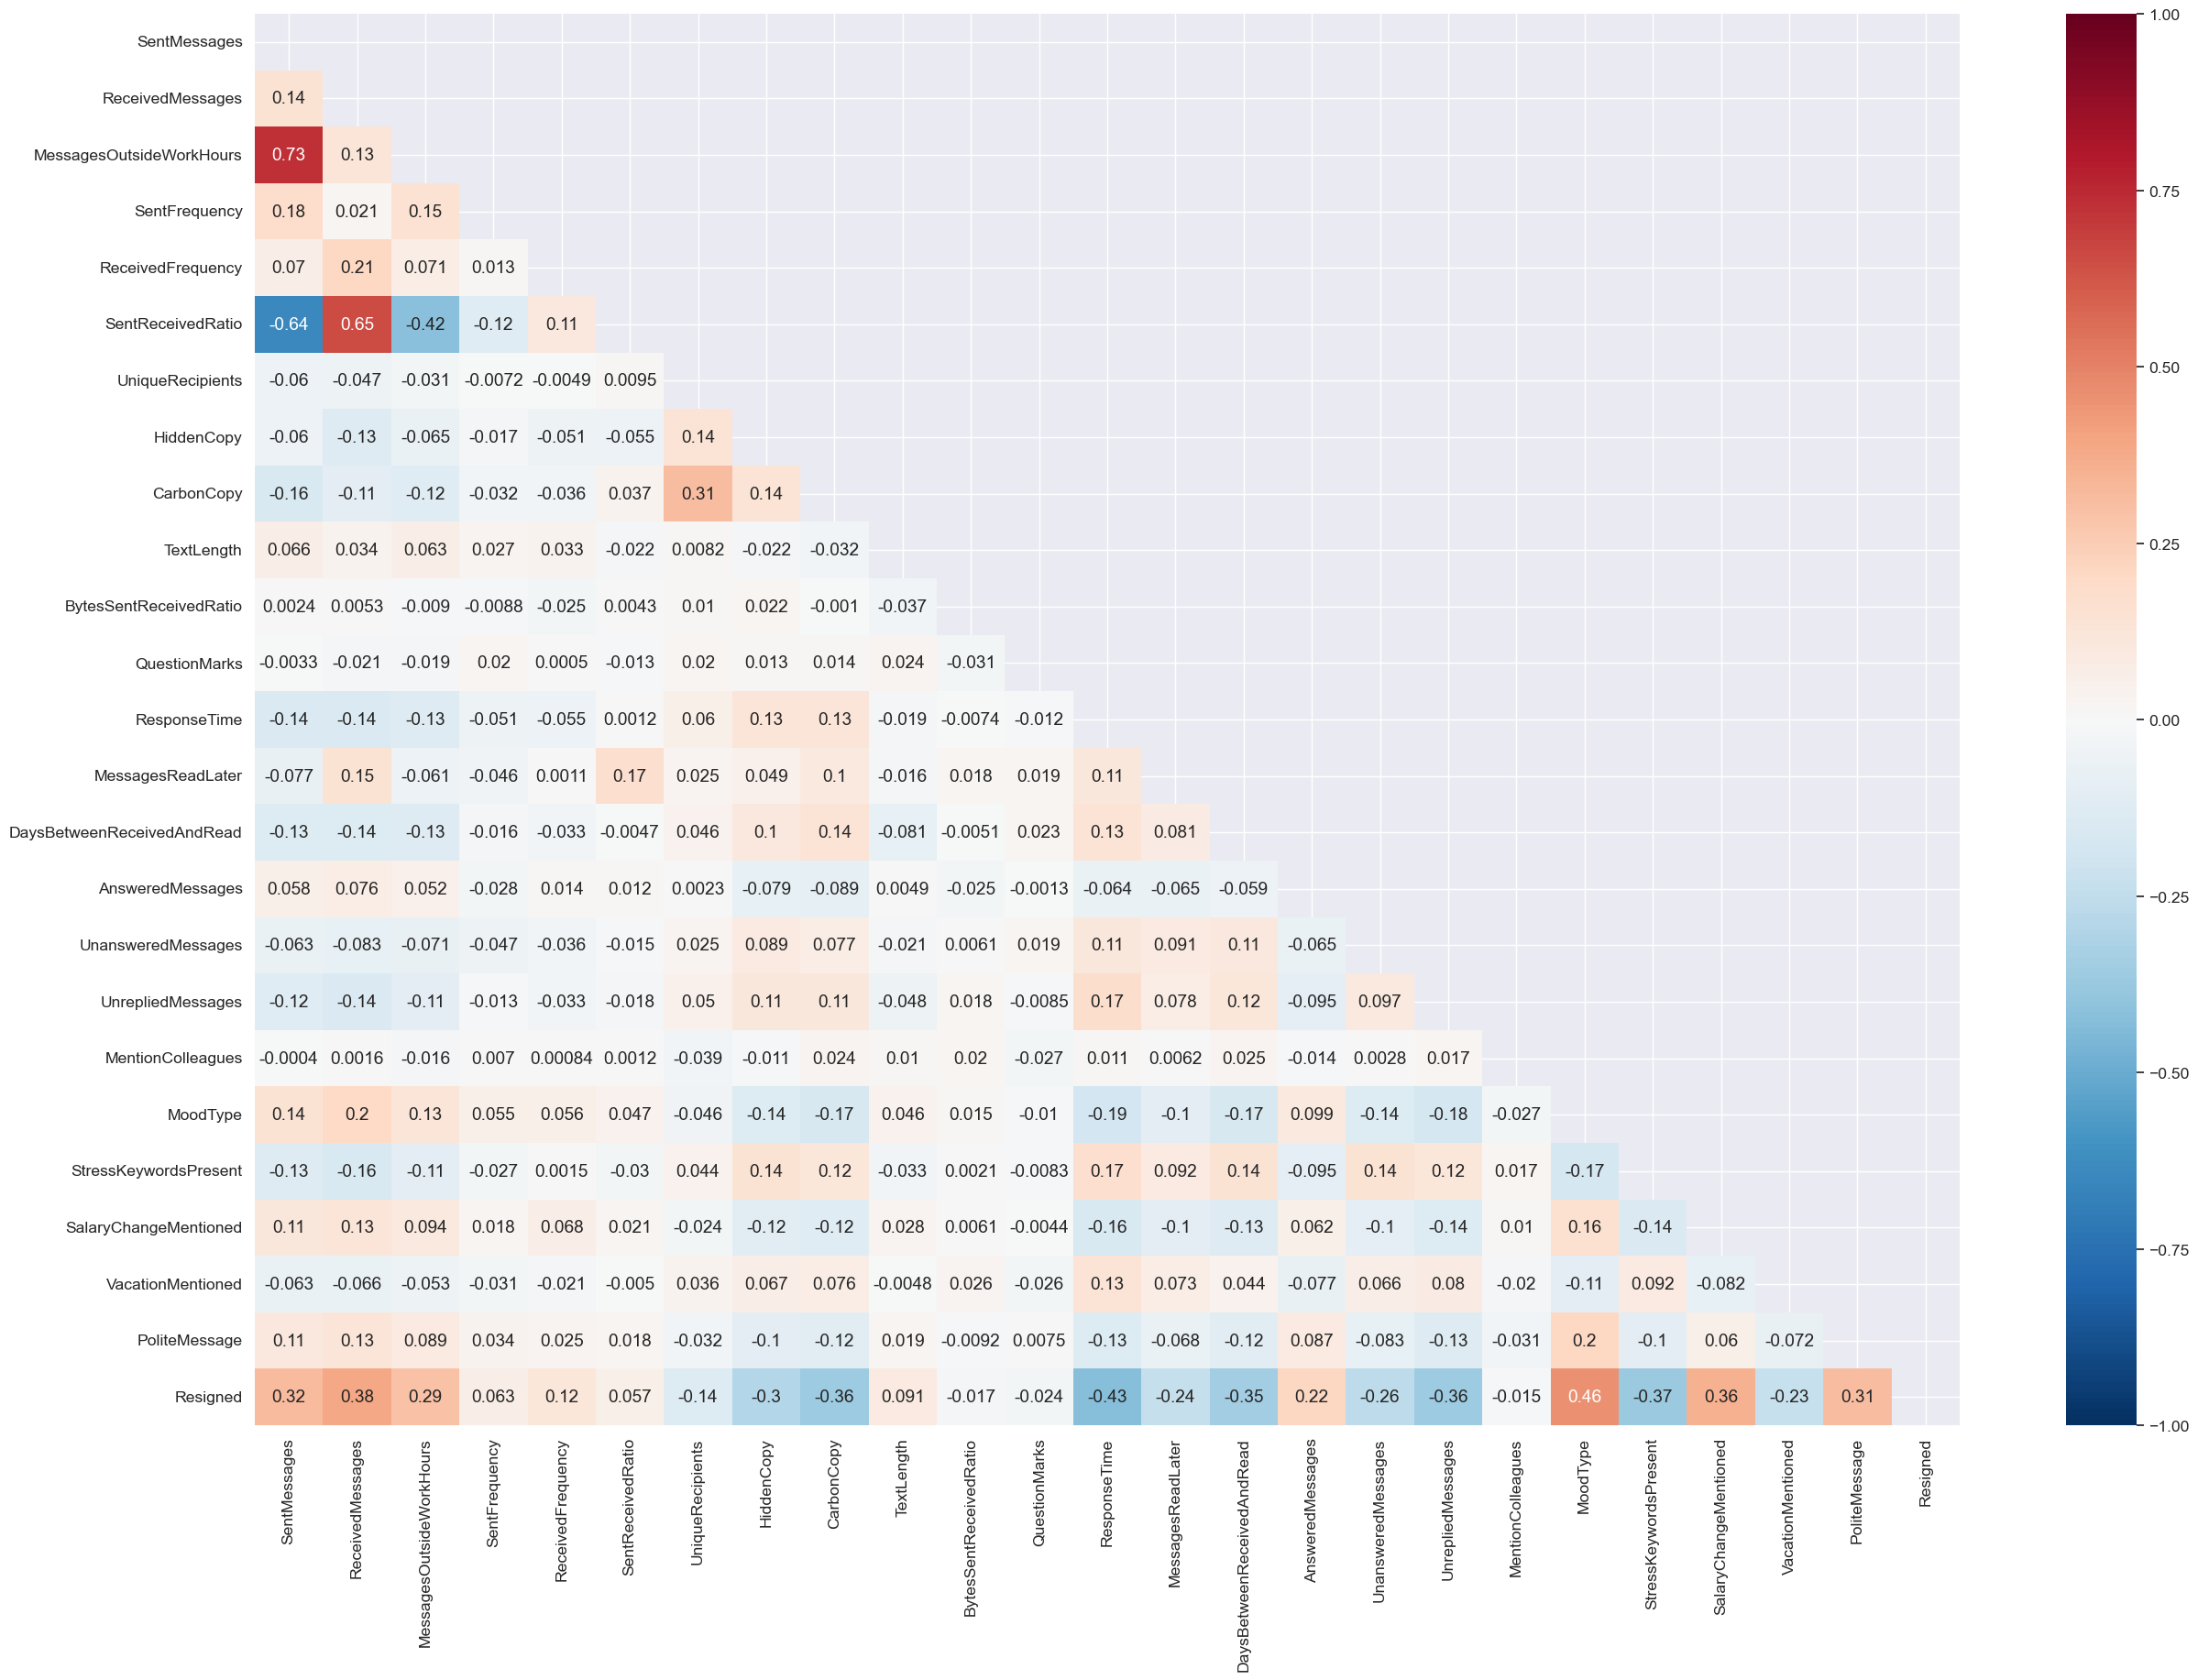

In [366]:
# Проверим корреляции
correlation_matrix = df.drop(columns=['id', 'Group']).corr()

plt.figure(figsize=(30,20))
sns.set(font_scale=1.15)
sns.heatmap(correlation_matrix,
            cmap='RdBu_r', # задаёт цветовую схему
            annot=True, # рисует значения внутри ячеек
            vmin=-1, vmax=1,
            mask=np.triu(correlation_matrix))

In [367]:
num_f = ['SentMessages', 'ReceivedMessages',
          'SentFrequency', 'ReceivedFrequency', 'SentReceivedRatio',
          'UniqueRecipients', 'TextLength',
          'BytesSentReceivedRatio']
joblib.dump(num_f, f'../data/num_f')

count_f = ['MessagesOutsideWorkHours', 'HiddenCopy', 'CarbonCopy', 'QuestionMarks', 'ResponseTime',
          'MessagesReadLater', 'DaysBetweenReceivedAndRead', 'AnsweredMessages',
          'UnansweredMessages', 'UnrepliedMessages']
joblib.dump(count_f, f'../data/count_f')

bin_f = ['MentionColleagues',
             'MoodType', 'StressKeywordsPresent', 'SalaryChangeMentioned',
             'VacationMentioned', 'PoliteMessage']
joblib.dump(bin_f, f'../data/bin_f')


['../data/bin_f']

In [368]:
cols_to_drop = ['Group']
# Сохранение в файл
filename = f'../data/cols_to_drop'

joblib.dump(cols_to_drop, filename)

cols_full = list(df.columns)
# Сохранение в файл
filename = f'../data/cols_full'

joblib.dump(cols_full, filename)

['../data/cols_full']

In [369]:
df = df.drop(index=sample.index)
df.to_csv('../data/train.csv', index=False)

In [364]:
df.head()

,id,SentMessages,ReceivedMessages,MessagesOutsideWorkHours,SentFrequency,ReceivedFrequency,SentReceivedRatio,UniqueRecipients,HiddenCopy,CarbonCopy,...,UnansweredMessages,UnrepliedMessages,MentionColleagues,MoodType,StressKeywordsPresent,SalaryChangeMentioned,VacationMentioned,PoliteMessage,Resigned,Group
0,1000,71,87,2,13,17,1.208333,9,2,5,...,11,10,1,0,2,0,1,0,0,Development Department
1,1001,68,61,2,15,14,0.884058,8,1,4,...,14,10,2,0,2,0,1,0,0,Development Department
2,1002,66,83,2,14,11,1.238806,9,1,3,...,10,11,1,0,0,0,0,0,1,IT Infrastructure
3,1003,73,110,2,11,19,1.486486,5,1,4,...,12,3,2,1,0,0,0,0,1,Quality Assurance
4,1004,61,84,2,13,13,1.354839,2,1,1,...,10,7,3,0,1,0,0,0,1,Quality Assurance


In [127]:
sample = df.sample(n=1, random_state=42).drop(columns=['Resigned', 'SentMessages'])
sample.to_csv('../data/test_not_valid.csv', index=False)